In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from geopy.distance import geodesic
from quetzal.model import stepmodel
from quetzal.analysis import analysis
from quetzal.engine.pathfinder import PublicPathFinder

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the LoS tables
## Saves a StepModel with shortest paths and LoS attributes for the PT network
## Needs aggregated PT networks

In [2]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')
ae = stepmodel.read_json(model_path + 'de_pt_access_egress')
aux = stepmodel.read_json(model_path + 'de_pt_network_ancillary')

In [4]:
sm.centroids = ae.centroids
sm.footpaths = ae.footpaths
sm.zone_to_transit = ae.zone_to_transit

In [5]:
sm.links.shape

(206192, 9)

### Prepare links for pathfinder

In [6]:
# Generate headways (two times the waiting time at a stop when changing between trips)
# ASSUMPTION: Take average headways for core hours between 6 a.m. and 8 p.m.
freq = aux.frequencies.loc[(aux.frequencies['hour']>=6) &
                           (aux.frequencies['hour']<=19)
                          ].groupby('stop_id').agg({'trip_id': 'sum'})
freq['trip_id'] = 14*3600 / freq['trip_id'] # 14 hours

In [7]:
headway_dict = freq['trip_id'].to_dict()

In [8]:
# ASSUMPTION: Maximum waiting time is 15 minutes, minumum is 5 minutes
sm.links['headway'] = sm.links['a'].map(headway_dict)
sm.links['headway'] = sm.links['headway'].replace(
    {np.nan: 15*60*2}).clip(lower=5*60*2, upper=15*60*2)

In [9]:
# ASSUMPTION: Air trips require security checks and so on...
sm.links.loc[sm.links['route_type']=='air', 'headway'] = 45*60*2
sm.links['headway'] = sm.links['headway'].astype(int)

<AxesSubplot:>

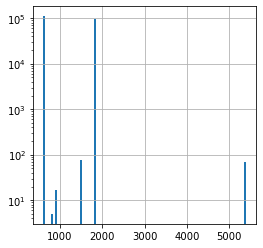

In [10]:
sm.links['headway'].hist(bins=100, figsize=(4,4), log=True)

In [11]:
# Reset access/egress time to zero
# Because it should not be a mode choice decision factor.
# LoS attribute accessibility will handle this.
#sm.zone_to_transit['time'] = 0

In [11]:
# Generate length for PT links as the crow flies
if 'length' not in sm.links.columns:
    tqdm.pandas()
    sm.links['length'] = sm.links['geometry'].progress_apply(
        lambda l: int(geodesic(l.coords[0], l.coords[-1]).m))

In [12]:
sm.links.sample()

,a,b,length,route_type,geometry,link_sequence,route_id,time,trip_id,headway
index,,,,,,,,,,
bus_247651,DE146_bus_0,DE145_1_bus_0,21261,bus,"LINESTRING (9.75289 48.11706, 9.77332 48.30974)",1,bus_1980,120,bus_20945,600


In [13]:
# Load OD pairs from volumes if available
od_set = None
try:
    v = stepmodel.read_json(model_path + 'de_volumes')
    od_set = set([tuple(l) for l in v.volumes[['origin', 'destination']].values.tolist()])
    print('Generated OD set with {} pairs'.format(len(od_set)))
except:
    print('The volumes file is not (yet) available')

Generated OD set with 217335 pairs


### Apply PT pathfinder
It generates the LoS table with shortest paths for each origin destination pair

In [15]:
'''This cell would run all possible mode combinations
sm.step_pt_pathfinder(
    broken_routes=False,
    broken_modes=True, # Allow different mode combinations
    route_column='route_id',
    mode_column='route_type',
    boarding_time=0, # Assumption
    alighting_time=0,
    speedup=True,
    walk_on_road=False,
    keep_pathfinder=False, # Saves it as attribute for multiple iterations
    force=False, # If indices are inconsistent
    path_analysis=True, # Create path, time and length columns
    drop_duplicates=True, # Considering duplicate paths
    cutoff=np.inf, # distance limit between points for Dijkstra algorithm
    od_set=od_set) # Exclude OD pairs that are not used'''

"This cell would run all possible mode combinations\nsm.step_pt_pathfinder(\n    broken_routes=False,\n    broken_modes=True, # Allow different mode combinations\n    route_column='route_id',\n    mode_column='route_type',\n    boarding_time=0, # Assumption\n    alighting_time=0,\n    speedup=True,\n    walk_on_road=False,\n    keep_pathfinder=False, # Saves it as attribute for multiple iterations\n    force=False, # If indices are inconsistent\n    path_analysis=True, # Create path, time and length columns\n    drop_duplicates=True, # Considering duplicate paths\n    cutoff=np.inf, # distance limit between points for Dijkstra algorithm\n    od_set=od_set) # Exclude OD pairs that are not used"

In [14]:
# We don't want the algorithm to search paths for all mode combinations.
# Thus, we have to extract the pathfinder and search them manually.
# This step yields shortest paths regardless of the mode combination.
'''sm.step_pt_pathfinder(
    broken_routes=False,
    broken_modes=False,
    keep_pathfinder=True, # get the PPF
    mode_column='route_type',
    route_column='route_id',
    speedup=True,
    cutoff=np.inf,
    walk_on_road=False,
    od_set=od_set,
    path_analysis=False,
)
ppf = sm.publicpathfinder
len(sm.pt_los)'''
ppf = PublicPathFinder(sm)

In [15]:
# Now, build custom mode combinations
# People just don't go by coach and then switch to rail or airplane within Germany
ppf.build_mode_combinations(mode_column='route_type')
ppf.mode_combinations = [x for x in ppf.mode_combinations
                         if not ('coach' in x and
                         ('rail_long' in x or
                          'rail_short' in x or
                          'air' in x))]
ppf.mode_combinations

[{'air', 'bus', 'rail_long', 'rail_short'},
 {'air', 'bus', 'rail_long'},
 {'air', 'bus', 'rail_short'},
 {'air', 'bus'},
 {'air', 'rail_long', 'rail_short'},
 {'air', 'rail_long'},
 {'air', 'rail_short'},
 {'air'},
 {'bus', 'coach'},
 {'bus', 'rail_long', 'rail_short'},
 {'bus', 'rail_long'},
 {'bus', 'rail_short'},
 {'bus'},
 {'coach'},
 {'rail_long', 'rail_short'},
 {'rail_long'},
 {'rail_short'},
 set()]

In [16]:
# Run the pathfinder for all mode combinations
# ASSUMPTION: Include a penalty for people to choose less transfers
transfer_penalty = 0#20*60
ppf.find_broken_mode_paths(workers=3, # CPU cores
                           cutoff=np.inf,
                           od_set=od_set,
                           mode_column='route_type',
                           boarding_time=transfer_penalty)

breaking modes: set() : 100%|██████████████████████████████████████████████████████████| 18/18 [25:05<00:00, 83.64s/it]


In [17]:
ppf.broken_mode_paths.sample()

,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes
150446,DEA41,DE21I,7738.0,"[DEA41, DEA41_bus_1, bus_1577022, DEA45_bus_0,...",False,mode_breaker,{rail_short}


In [18]:
# Run the path analysis and assign paths as LoS table
sm.pt_los = analysis.path_analysis_od_matrix(
    od_matrix=ppf.broken_mode_paths,
    links=sm.links,
    nodes=sm.nodes,
    centroids=sm.centroids)

path_analysis: 100%|██████████████████████████████████████████████████████| 3699320/3699320 [02:18<00:00, 26640.93it/s]


In [19]:
print(len(sm.pt_los.index))
sm.pt_los.loc[sm.pt_los['origin']!=sm.pt_los['destination']].sample(3)

3699320


,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,node_path,link_path,footpaths,ntlegs,transfers,boarding_links,alighting_links,all_walk,ntransfers,time_link_path,length_link_path
147323,DEA33,DE735,5624.0,"[DEA33, DEA33_bus_0, bus_828144, DEA38_bus_0, ...",False,mode_breaker,"{air, rail_short}","[DEA33_bus_0, DEA38_bus_0, DEA5B_bus_1, DEA57_...","[DEA38_bus_0, DEA5B_bus_1, DEA57_1_bus_0, DE73...","[DEA33_bus_0, DEA38_bus_0, DEA5B_bus_1, DEA57_...","[bus_828144, bus_2765001, bus_1375702, bus_984...",[],"[(DEA33, DEA33_bus_0), (DE735_bus_2, DE735)]","[DEA38_bus_0, DEA5B_bus_1, DEA57_1_bus_0, DE73...","[bus_828144, bus_2765001, bus_1375702, bus_984...","[bus_828144, bus_2765001, bus_1375702, bus_984...",False,4,540,217680
134951,DEA13,DEG0F,8421.0,"[DEA13, DEA13_bus_4, bus_708680, DEA56_bus_0, ...",False,mode_breaker,{coach},"[DEA13_bus_4, DEA56_bus_0, DEA2A_bus_0, DEA58_...","[DEA56_bus_0, DEA2A_bus_0, DEA58_bus_0, DEA57_...","[DEA13_bus_4, DEA56_bus_0, DEA2A_bus_0, DEA58_...","[bus_708680, bus_1022334, bus_1873643, bus_999...","[(DEG0N_bus_0, rail_long_node_1273), (rail_lon...","[(DEA13, DEA13_bus_4), (DEG0F_r_s_0, DEG0F)]","[DEA56_bus_0, DEA2A_bus_0, DEA58_bus_0, DEA57_...","[bus_708680, bus_1022334, bus_1873643, bus_999...","[bus_708680, bus_1022334, bus_1873643, bus_999...",False,10,2460,517744
47006,DE236,DEA28,9259.0,"[DE236, DE236_r_s_0, DE236_bus_0, bus_2943521,...",False,mode_breaker,"{air, rail_long}","[DE236_bus_0, DE25B_bus_0, DE256_2_bus_0, DE25...","[DE25B_bus_0, DE256_2_bus_0, DE256_1_bus_0, DE...","[DE236_r_s_0, DE236_bus_0, DE25B_bus_0, DE256_...","[bus_2943521, bus_1519696, bus_1109874, bus_20...","[(DE236_r_s_0, DE236_bus_0), (DEA27_bus_0, DEA...","[(DE236, DE236_r_s_0), (DEA28_r_s_0, DEA28)]","[DE25B_bus_0, DE256_2_bus_0, DE256_1_bus_0, DE...","[bus_2943521, bus_1519696, bus_1109874, bus_20...","[bus_2943521, bus_1519696, bus_1109874, bus_20...",False,11,1560,688367


### Add attributes to LoS table

In [20]:
# Disaggregate time into in-vehicle and access/egress
sm.analysis_pt_time(boarding_time=0)
print(sm.pt_los.columns)

Index(['origin', 'destination', 'gtime', 'path', 'reversed',
       'pathfinder_session', 'broken_modes', 'boardings', 'alightings',
       'node_path', 'link_path', 'footpaths', 'ntlegs', 'transfers',
       'boarding_links', 'alighting_links', 'all_walk', 'ntransfers',
       'time_link_path', 'length_link_path', 'access_time', 'footpath_time',
       'in_vehicle_time', 'waiting_time', 'boarding_time', 'time'],
      dtype='object')


In [21]:
sm.pt_los[['ntransfers']+[c for c in sm.pt_los.columns if c[-4:]=='time']].sample(2)

,ntransfers,gtime,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time
25523,11,7494.0,1579,935,1380,3600.0,0,7494.0
211451,7,4956.0,1536,0,1020,2400.0,0,4956.0


In [22]:
# Add price, parametrisation comes later
sm.pt_los['price'] = 0

In [23]:
# Add distances
len_dict = sm.links['length'].to_dict()
sm.pt_los['length'] = sm.pt_los['link_path'].apply(lambda p: sum([len_dict[l] for l in p]))

In [24]:
# Add route_types
type_dict = sm.links['route_type'].to_dict()
sm.pt_los['route_types'] = [set([type_dict[link] for link in l])
                            for l in list(sm.pt_los['link_path'])]

In [25]:
# Add main route_type based on a hierarchy
hierarchy = ['air', 'coach', 'rail_long', 'rail_short', 'bus', 'walk']
def main_type(types):
    t = hierarchy[-1]
    try:
        t = hierarchy[min([hierarchy.index(t) for t in types])]
    except ValueError: # empty types set
        pass
    return t
sm.pt_los['route_type'] = sm.pt_los['route_types'].apply(main_type)

In [28]:
# Add number of transfers
#sm.pt_los['ntransfers'] = sm.pt_los['boardings'].apply(lambda l: max(0, len(l) - 1))

In [26]:
sm.pt_los.sample(2)

,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,node_path,...,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time,price,length,route_types,route_type
114140,DE91B_2,DE712,20873.0,"[DE91B_2, rail_long_node_599, coach_node_FLIXB...",False,mode_breaker,"{bus, rail_short, rail_long}",[coach_node_FLIXBUS:47],[coach_node_FLIXBUS:12],"[rail_long_node_599, coach_node_FLIXBUS:47, co...",...,3067,406,16500,900.0,0,20873.0,0,278822,{coach},coach
189369,DED52,DE80O_2,14119.0,"[DED52, rail_long_node_82, rail_long_node_704,...",False,mode_breaker,"{bus, rail_short}","[rail_long_node_704, rail_long_node_671]","[rail_long_node_863, rail_long_node_452]","[rail_long_node_82, rail_long_node_704, rail_l...",...,4699,0,7620,1800.0,0,14119.0,0,398683,{rail_long},rail_long


In [27]:
# Make a copy before restricting results
los = sm.pt_los.copy()

In [71]:
#sm.pt_los = los.copy()

### Clean PT LOS

In [72]:
# Drop trips with coach-rail or coach-air combinations
sm.pt_los = sm.pt_los.loc[~sm.pt_los['route_types'].apply(
    lambda x: 'coach' in x and ('rail_long' in x or 'rail_short' in x or 'air' in x))]
sm.pt_los.shape

(3439788, 30)

In [73]:
# Drop unrealistically long trips
sm.pt_los = sm.pt_los.loc[sm.pt_los['in_vehicle_time']<10*3600]
sm.pt_los.shape

(3432391, 30)

In [75]:
# Drop duplicates
sm.pt_los['path'] = sm.pt_los['path'].apply(tuple)
sm.pt_los.drop_duplicates('path', inplace=True)
sm.pt_los.reset_index(inplace=True)
sm.pt_los.shape

(2767052, 31)

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

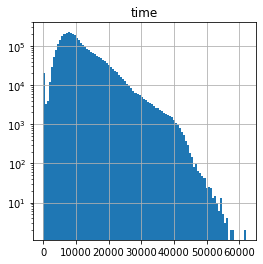

In [74]:
# Time distribution
sm.pt_los.hist(column='time', bins=100, figsize=(4,4), log=True)

array([[<AxesSubplot:title={'center':'ntransfers'}>]], dtype=object)

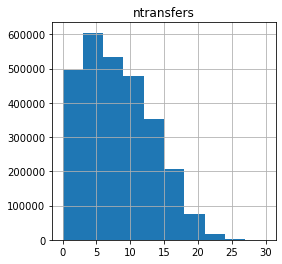

In [76]:
sm.pt_los.hist(column='ntransfers', figsize=(4,4))

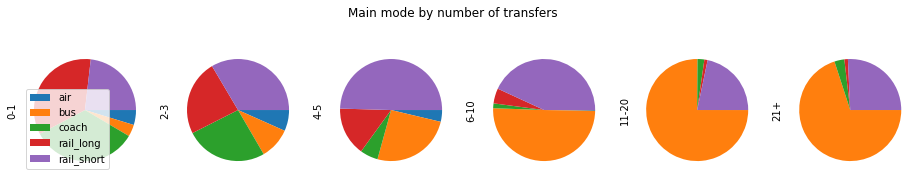

In [77]:
# Main mode distribution by transfers
t = sm.pt_los.copy()
t['bins'] = pd.cut(t['ntransfers'], bins=[0,1,3,5,10,20,100],
                   labels=["0-1", "2-3","4-5","6-10","11-20","21+"])
axs = t.groupby(['route_type','bins']).size().unstack(fill_value=0).plot.pie(
    subplots=True, figsize=(16, 3),
    startangle=0, counterclock=False, title='Main mode by number of transfers',
    legend=False, labeldistance=None)
axs[0].legend(loc='lower left')

<AxesSubplot:xlabel='route_types'>

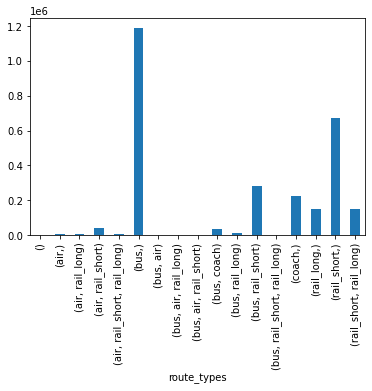

In [78]:
# Distribution of mode combinations
t['route_types'] = t['route_types'].apply(tuple)
t.groupby('route_types').count()['route_type'].plot(kind='bar')

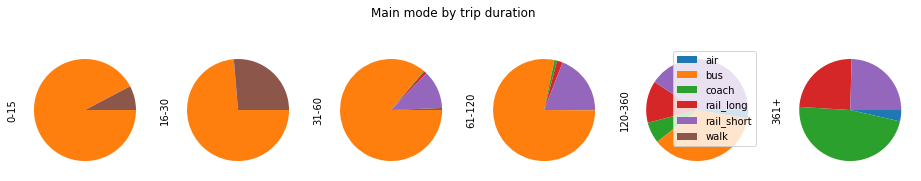

In [79]:
t['time'] = t['time'] / 60
t['bins'] = pd.cut(t['time'], bins=[0,15,30,60,120,360,500],
                   labels=["0-15", "16-30","31-60","61-120","120-360","361+"])
axs = t.groupby(['route_type','bins']).size().unstack(fill_value=0).plot.pie(
    subplots=True, figsize=(16, 3),
    startangle=0, counterclock=False, title='Main mode by trip duration',
    legend=False, labeldistance=None)
axs[-2].legend()

In [80]:
t = None

In [82]:
# Drop unnecessary long connections if there is a waiting time applied
if sm.links['headway'].mean() > 5*60:
    sm.pt_los = sm.pt_los.loc[sm.pt_los['ntransfers']<=10]
    print(sm.pt_los.shape)
    # Drop coach connections with more than one transfer
    sm.pt_los = sm.pt_los.loc[~((sm.pt_los['route_type']=='coach') &
                                (sm.pt_los['boardings'].apply(
                                    lambda l: len([n for n in l if n.startswith('coach')])>2)
                                ))]
    print(sm.pt_los.shape)

(1204532, 31)
(1067297, 31)


In [81]:
# Keep only the fastest trip(s)
sm.pt_los['route_types'] = sm.pt_los['route_types'].apply(tuple)
sm.pt_los = sm.pt_los.sort_values('time').groupby(
    ['origin', 'destination', 'route_types']).nth([0, 1]).reset_index()
sm.pt_los.shape

(1461204, 31)

<AxesSubplot:xlabel='route_types'>

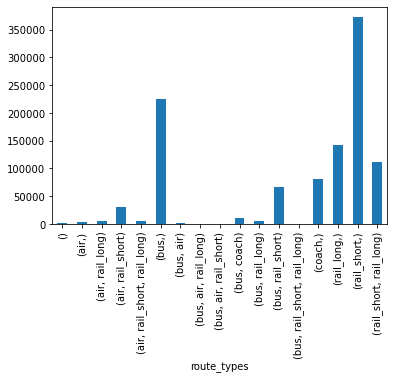

In [83]:
sm.pt_los.groupby('route_types').count()['route_type'].plot(kind='bar')

### Save model

In [85]:
# Ditch unneccessary columns
to_drop = ['gtime', 'path', 'reversed', 'pathfinder_session',
           'broken_modes', 'boardings', 'alightings', 'node_path',
           'footpaths', 'ntlegs', 'transfers', 'boarding_links',
           'alighting_links', 'all_walk', 'time_link_path',
           'length_link_path', 'boarding_time', 'index']
sm.pt_los = sm.pt_los.drop(to_drop, axis=1, errors='ignore')

In [86]:
# Clean links table
to_drop = ['duration', 'cost', 'origin', 'destination']
sm.links = sm.links.drop(to_drop, axis=1, errors='ignore')

In [87]:
# Make table smaller
cols = ['time', 'access_time', 'in_vehicle_time', 'footpath_time',
        'waiting_time', 'length']
sm.pt_los[cols] = sm.pt_los[cols].astype(int)

In [88]:
sm.pt_los.sample()

,origin,destination,route_types,link_path,ntransfers,access_time,footpath_time,in_vehicle_time,waiting_time,time,price,length,route_type
1304466,DEE07,DEA27,"(rail_short,)","[r_s_178534, r_s_100722, r_s_143233, r_s_14323...",7,1618,0,6580,7200,15398,0,607540,rail_short


In [89]:
# Saving LoS...
sm.to_json(model_path + 'de_pt_los', only_attributes=['pt_los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 35/35 [00:16<00:00,  2.06it/s]


In [90]:
# Split links in graph and auxiliary information
# for file sizes being compatible with github's size limit
cols = ['link_sequence', 'route_id', 'time', 'trip_id', 'length', 'headway']
auxiliary = sm.links[cols]
sm.links.drop(cols, axis=1, inplace=True)

In [91]:
sm.to_json(model_path + 'de_pt_network_agg', only_attributes=[
    'zones', 'links', 'nodes', 'pt_route_types'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 35/35 [00:31<00:00,  1.10it/s]


In [92]:
# Save auxiliary information seperately
auxiliary['index'] = auxiliary.index
auxiliary.reset_index(drop=True, inplace=True)
auxiliary.to_json(model_path + 'de_pt_network_agg/links_quetzaldata.json')